In [ ]:
import torch
import matplotlib
import torch.nn as nn
import torch.nn.functional as F

from utils.plot import visualize
from utils.encoder import ResNet18Encoder
from utils.dataset import get_dataloaders
from torchvision.ops import box_iou, nms

trainloader, valloader = get_dataloaders(batch_size=4)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)

In [ ]:
sample, target = next(iter(trainloader))
sample = torch.stack(sample, dim=0)

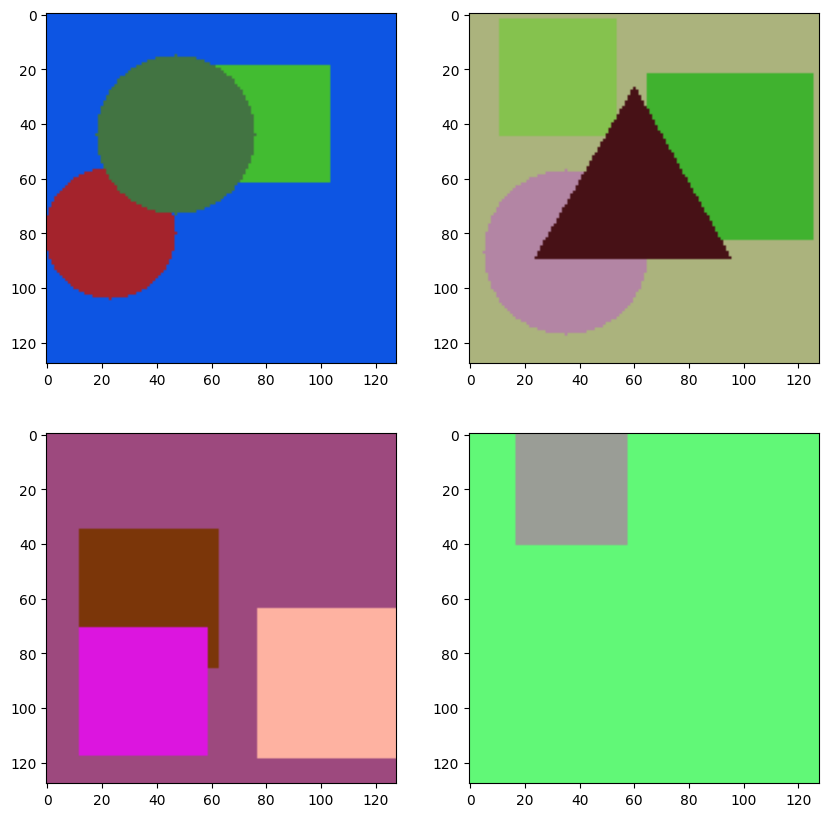

In [ ]:
visualize(sample)

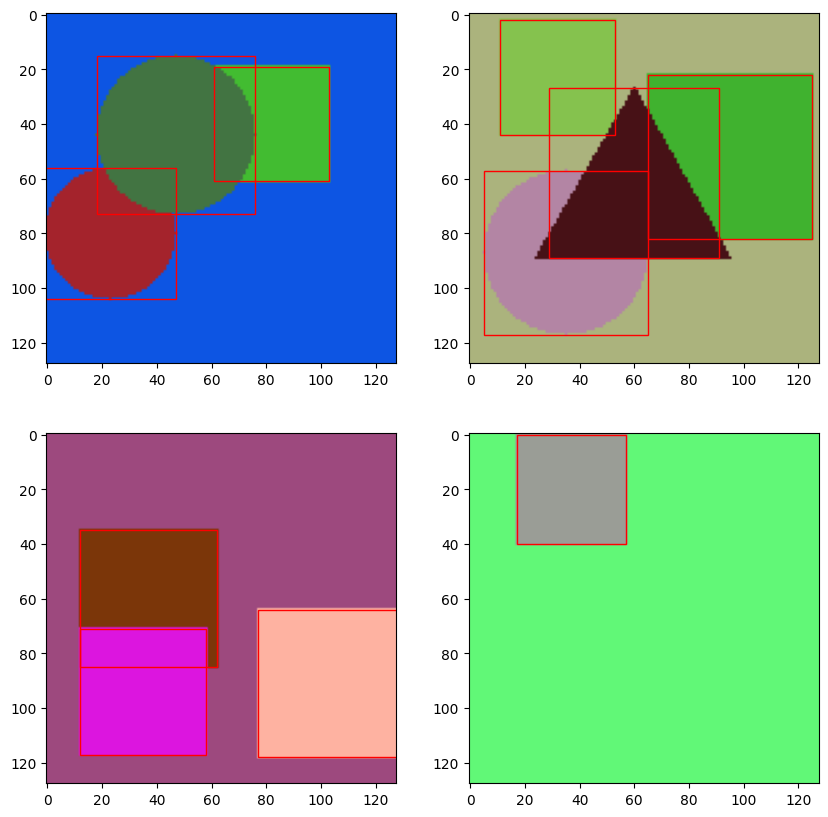

In [ ]:
visualize(sample, target)

In [ ]:
print(target[0])

{'bounding_box': tensor([[ 61,  19, 103,  61],
        [ -1,  56,  47, 104],
        [ 18,  15,  76,  73]]), 'labels': tensor([1, 2, 2], dtype=torch.int32)}


In [ ]:
def get_anchors():
    """
    Generate 192 boxes where each box is represented by :
    [top_left_x, top_left_y, bottom_right_x, bottom_right_y]

    Each anchor position should generate 3 boxes according to the scales and ratios given.

    Return this result as a torch tensor of size [192,4]
    """
    stride = 16
    image_size = 128
    scales = [40, 50, 60]

    anchors = []
    num_anchors_one_dim = image_size // stride
    for anchor_size in scales:
        for i in range(num_anchors_one_dim):
            for j in range(num_anchors_one_dim):
                x = i * stride
                y = j * stride

                x2 = x + anchor_size
                y2 = y + anchor_size


                anchors.append([x, y, x2, y2])


    return torch.tensor(anchors, dtype=torch.float32)



anchors = get_anchors()
print(anchors)
assert anchors.size() == (192,4)

tensor([[  0.,   0.,  40.,  40.],
        [  0.,  16.,  40.,  56.],
        [  0.,  32.,  40.,  72.],
        [  0.,  48.,  40.,  88.],
        [  0.,  64.,  40., 104.],
        [  0.,  80.,  40., 120.],
        [  0.,  96.,  40., 136.],
        [  0., 112.,  40., 152.],
        [ 16.,   0.,  56.,  40.],
        [ 16.,  16.,  56.,  56.],
        [ 16.,  32.,  56.,  72.],
        [ 16.,  48.,  56.,  88.],
        [ 16.,  64.,  56., 104.],
        [ 16.,  80.,  56., 120.],
        [ 16.,  96.,  56., 136.],
        [ 16., 112.,  56., 152.],
        [ 32.,   0.,  72.,  40.],
        [ 32.,  16.,  72.,  56.],
        [ 32.,  32.,  72.,  72.],
        [ 32.,  48.,  72.,  88.],
        [ 32.,  64.,  72., 104.],
        [ 32.,  80.,  72., 120.],
        [ 32.,  96.,  72., 136.],
        [ 32., 112.,  72., 152.],
        [ 48.,   0.,  88.,  40.],
        [ 48.,  16.,  88.,  56.],
        [ 48.,  32.,  88.,  72.],
        [ 48.,  48.,  88.,  88.],
        [ 48.,  64.,  88., 104.],
        [ 48.,

In [ ]:
class ShapesModel(nn.Module):

    def __init__(self):
        super().__init__()

        # for each grid in the feature map we have 3 anchors of sizes: 40x40, 50x50, 60x60
        num_anchors = 3

        # regular resnet 18 encoder
        self.encoder = ResNet18Encoder()

        # a small conv net
        self.conv = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)

        self.cls = nn.Conv2d(256, num_anchors, kernel_size=1)

        self.reg = nn.Conv2d(256, num_anchors*4, kernel_size=1)


    def permute_and_flatten(self, layer, N, A, C, H, W):
        # helper function that rearranges the input for the loss function

        layer = layer.view(N, -1, C, H, W)
        layer = layer.permute(0, 3, 4, 1, 2)
        layer = layer.reshape(N, -1, C)

        return layer


    def post_process(self, cls_pred, reg_pred):
        # helper function that gets outputs in the right shape for applying the loss

        N, AxC, H, W = cls_pred.size()
        Ax4 = reg_pred.size(1)

        A = Ax4 // 4
        C = AxC // A

        cls_pred = self.permute_and_flatten(
            cls_pred, N, A, C, H, W
        )

        reg_pred = self.permute_and_flatten(
            reg_pred, N, A, 4, H, W
        )

        return cls_pred.squeeze(), reg_pred.squeeze()


    def forward(self, x):

        x = self.encoder(x)

        # we take the 3rd output feature map of
        # size 8 x 8 from the resnet18 encoder

        x = x[3]

        x = F.relu(self.conv(x))

        cls_pred = self.cls(x)
        reg_pred = self.reg(x)

        cls_pred, reg_pred = self.post_process(cls_pred, reg_pred)

        return cls_pred, reg_pred


In [ ]:
model = ShapesModel()
#model = model.to(device)
sample, target = next(iter(trainloader))
sample = torch.stack(sample, dim=0)
cls_pred, reg_pred = model(sample)

assert cls_pred.size() == (4, 192) and reg_pred.size() == (4, 192, 4)

In [ ]:
def compute_offsets(targets, anchors):
    """
    This function returns the offsets that need to applied to anchors to morph them into targets.
    Both anchors and targets should be of the same shape, N x 4.
    The output would be offsets given in a torch tensor of size N x 4.
    """
    t_width = targets[:, 2] - targets[:, 0]
    t_height = targets[:, 3] - targets[:, 1]
    t_center_x = targets[:, 0] + 0.5 * t_width
    t_center_y = targets[:, 1] + 0.5 * t_height

    a_width = anchors[:, 2] - anchors[:, 0]
    a_height = anchors[:, 3] - anchors[:, 1]
    a_center_x = anchors[:, 0] + 0.5 * a_width
    a_center_y = anchors[:, 1] + 0.5 * a_height

    delta_x = (a_center_x - t_center_x) / t_width
    delta_y = (a_center_y - t_center_y) / t_height
    delta_scale_x = torch.log(a_width / t_width)
    delta_scale_y = torch.log(a_height / t_height)

    offsets = torch.cat(
        [
            delta_x.unsqueeze(0),
            delta_y.unsqueeze(0),
            delta_scale_x.unsqueeze(0),
            delta_scale_y.unsqueeze(0),
        ],
        dim=0,
    )
    return offsets.permute(1, 0)

In [ ]:
def get_labels_and_offsets(targets, anchors):
    '''
    INPUT:
    targets: [N x 4]: Bounding boxes in the image.
    anchors: [192 x 4]: Anchor boxes of an image.

    OUTPUT:
    labels: [192 x 1]: Class labels for each anchor. 1 is for foreground, 0 is for background and -1 is for a bad anchor.
    offsets: [192 x 4]: Offsets for anchor to best fit the bounding box object. Calculated if class label is 1.

    '''
    high_threshold = 0.7
    low_threshold = 0.3
    targets = targets.to(device)
    anchors = anchors.to(device)
    N = anchors.size(0)

    ious = box_iou(targets, anchors)

    # Find the maximum IoU for each anchor
    max_ious = ious.max(axis=0)
    max_iou_indices = max_ious.indices
    max_ious = max_ious.values

    # Initialize labels as -1 (bad anchors)
    labels = torch.full((N,), -1, dtype=torch.float32)
    labels = labels.to(device)
    # Set anchors with IoU < low_threshold as negative (background)
    labels[max_ious < low_threshold] = 0

    # Set anchors with IoU > high_threshold as positive (foreground)
    labels[max_ious > high_threshold] = 1


    offsets = compute_offsets(targets[max_iou_indices], anchors)
    offsets = offsets.to(device)


   # return labels, all_offsets
   # print(labels.squeeze())
   # print(offsets.squeeze())
    return labels.squeeze(), offsets.squeeze()

In [ ]:
from torchvision.ops import box_iou

def get_labels_and_offsetsO(targets, anchors):
    high_threshold = 0.7
    low_threshold = 0.3

    targets = targets.to(device)
    anchors = anchors.to(device)
    # Compute IoU between each anchor and each target
    ious = box_iou(targets, targets)

    # For each anchor, find the maximum IoU across all targets
    max_ious, max_iou_indices = ious.max(dim=1)


    labels = torch.full((anchors.size(0),), -1, dtype=torch.float32)
    labels = labels.to(device)
    # Set labels to 0 or 1 based on the IoU thresholds
    labels[max_ious < low_threshold] = 0
    labels[max_ious > high_threshold] = 1
    #print(labels)
    # Compute offsets for anchors with label 1
    offsets = torch.zeros_like(anchors)
    offsets = offsets.to(device)
    positive_indices = torch.where(labels == 1)[0]
    #print(anchors[positive_indices].size(), targets[max_iou_indices[positive_indices]].size())
    offsets[positive_indices] = compute_offsets(targets[max_iou_indices[positive_indices]], anchors[positive_indices])
    print(labels)
    #print(offsets)
    return labels, offsets

In [ ]:
def get_batch(sample, target):
    '''
    Input
    target => Set of bounding boxes for each image.
    Sample => Each image
    Output:
    Bounding box offsets and class labels for each anchor.
    '''

    all_labels = []
    all_offsets = []
    for s, t in zip(sample, target):
        targets = t['bounding_box'].to(device)
        labels, offsets = get_labels_and_offsets(targets, anchors)
        all_labels.append(labels)
        all_offsets.append(offsets)

    all_labels = torch.stack(all_labels, dim=0)
    all_offsets = torch.stack(all_offsets, dim=0)

    return all_labels, all_offsets

In [ ]:
sample, target = next(iter(trainloader))
sample = torch.stack(sample, dim=0)

labels, offsets = get_batch(sample, target)
assert labels.size() == (4, 192) and offsets.size() == (4, 192, 4)

In [ ]:
def label_lossO(pred_label, gt_label):
    mask = (gt_label >= 0)
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(pred_label[mask], gt_label[mask])

    return loss


def offset_lossO(pred_offset, gt_offset, gt_label):
    mask = (gt_label == 1)

    criterion = nn.SmoothL1Loss(reduction='sum')
    loss = criterion(pred_offset[mask], gt_offset[mask])

    return loss


In [ ]:
def label_loss(pred_label, gt_label):

    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3.0, device=pred_label.device))

    mask = (gt_label != -1)
    input = pred_label[mask]
    target = gt_label[mask].float()
    loss = criterion(input, target)
    return loss

def offset_loss(pred_offset, gt_offset, gt_label):

    criterion = nn.SmoothL1Loss()

    mask = (gt_label == 1)
    input = pred_offset[mask]
    target = gt_offset[mask]
    loss = criterion(input, target)
    return loss

In [ ]:
def train(epoch, model, trainloader, optimizer):
        total_loss = 0
        running_offset_loss = 0
        running_label_loss = 0
        for i, (images, targets) in enumerate(trainloader):
            images = torch.stack(images, dim=0).to(device)
            gt_labels, gt_offsets = get_batch(images, targets)
            pred_labels, pred_offsets = model(images)
            loss_label = label_loss(pred_labels, gt_labels)
            loss_offset = offset_loss(pred_offsets, gt_offsets, gt_labels)
            loss = loss_label + loss_offset

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_label_loss += loss_label.item()
            running_offset_loss += loss_offset.item()

            if (i+1) % 500 == 0:
                print(f'Iter {i+1} | Class Loss: {running_label_loss / (i+1)} Offset Loss: {running_offset_loss / (i+1)}')

        avg_running_label_loss = float(running_label_loss / len(trainloader))
        avg_running_offset_loss = float(running_offset_loss / len(trainloader))
        print(f'Epoch: {epoch+1} | Class Loss: {avg_running_label_loss}, Offset Loss: {avg_running_offset_loss} \n')

In [ ]:

model = ShapesModel()
model.to(device)
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.01, momentum=0.9, weight_decay=1e-4
)

for epoch in range(5):
    train(epoch, model, trainloader, optimizer)

Iter 500 | Class Loss: 0.15494118410348892 Offset Loss: 0.010293385486118495
Iter 1000 | Class Loss: 0.14528832349926232 Offset Loss: 0.006938064865535125
Iter 1500 | Class Loss: 0.14072896463423967 Offset Loss: 0.005771111345151439
Iter 2000 | Class Loss: 0.13718295792117716 Offset Loss: 0.005125484597549075
Iter 2500 | Class Loss: 0.1342758616283536 Offset Loss: 0.004745898805628531
Epoch: 1 | Class Loss: 0.1342758616283536, Offset Loss: 0.004745898805628531 

Iter 500 | Class Loss: 0.11889008790999651 Offset Loss: 0.0031625025938265025
Iter 1000 | Class Loss: 0.11545977642387152 Offset Loss: 0.003162868252256885
Iter 1500 | Class Loss: 0.11426401439805825 Offset Loss: 0.0031455781660818805
Iter 2000 | Class Loss: 0.11163429401814938 Offset Loss: 0.003131414212170057
Iter 2500 | Class Loss: 0.11010972005575895 Offset Loss: 0.0031175626981072126
Epoch: 2 | Class Loss: 0.11010972005575895, Offset Loss: 0.0031175626981072126 

Iter 500 | Class Loss: 0.0969783100746572 Offset Loss: 0.003

In [ ]:
sample, target = next(iter(valloader))
sample = torch.stack(sample,dim=0)

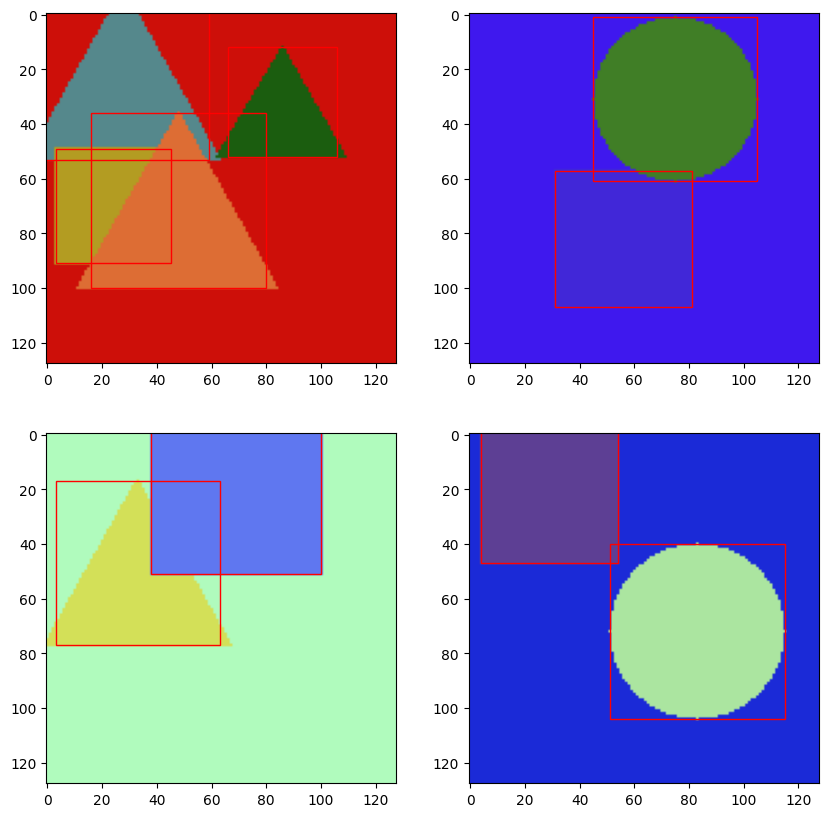

In [ ]:
visualize(sample, target)

In [ ]:
def apply_offsets(anchors, offsets):
    ]

    anchor_width = anchors[:, 2] - anchors[:, 0]
    anchor_height = anchors[:, 3] - anchors[:, 1]
    anchor_center_x = anchors[:, 0] + anchor_width / 2
    anchor_center_y = anchors[:, 1] + anchor_height / 2

    delta_x = offsets[:, 0]
    delta_y = offsets[:, 1]
    delta_scale_x = offsets[:, 2]
    delta_scale_y = offsets[:, 3]

    target_width = anchor_width / torch.exp(delta_scale_x)
    target_height = anchor_height / torch.exp(delta_scale_y)
    target_center_x = anchor_center_x - delta_x * target_width
    target_center_y = anchor_center_y - delta_y * target_height

    target_top_left_x, target_bottom_right_x = target_center_x - target_width / 2, target_center_x + target_width / 2
    target_top_left_y, target_bottom_right_y = target_center_y - target_height / 2, target_center_y + target_height / 2

    targets = torch.cat(
        [
            target_top_left_x.unsqueeze(0),
            target_top_left_y.unsqueeze(0),
            target_bottom_right_x.unsqueeze(0),
            target_bottom_right_y.unsqueeze(0),
        ],
        dim=0,
    )
    return targets.permute(1, 0)

In [1]:
def visualize_predsO(model, sample):
    model = model.to('cpu')

    label_preds, offset_preds = model(sample)
    #print(label_preds)
    foreground_threshold = 0
    foreground_mask = (label_preds.sigmoid() > foreground_threshold)

    # Ensure that the mask has the correct shape


    foreground_mask = foreground_mask.t()

    selected_anchors = anchors[foreground_mask]
    print(selected_anchors.size())
    adjusted_anchors = apply_offsets(selected_anchors, offset_preds)


    print(selected_anchors.size())
    #print(selected_offsets.size())
    # Apply the offsets to the selected anchors
    predictions = apply_offsets(selected_anchors, compute_offsets(selected_offsets, selected_anchors))

    # Use NMS to filter out overlapping boxes
    scores = label_preds[foreground_mask].sigmoid()
    keep = nms(predictions, scores, iou_threshold=0.5)
    predictions = predictions[keep]
    visualize(sample, predictions)


visualize_predsO(model, sample)

NameError: name 'model' is not defined

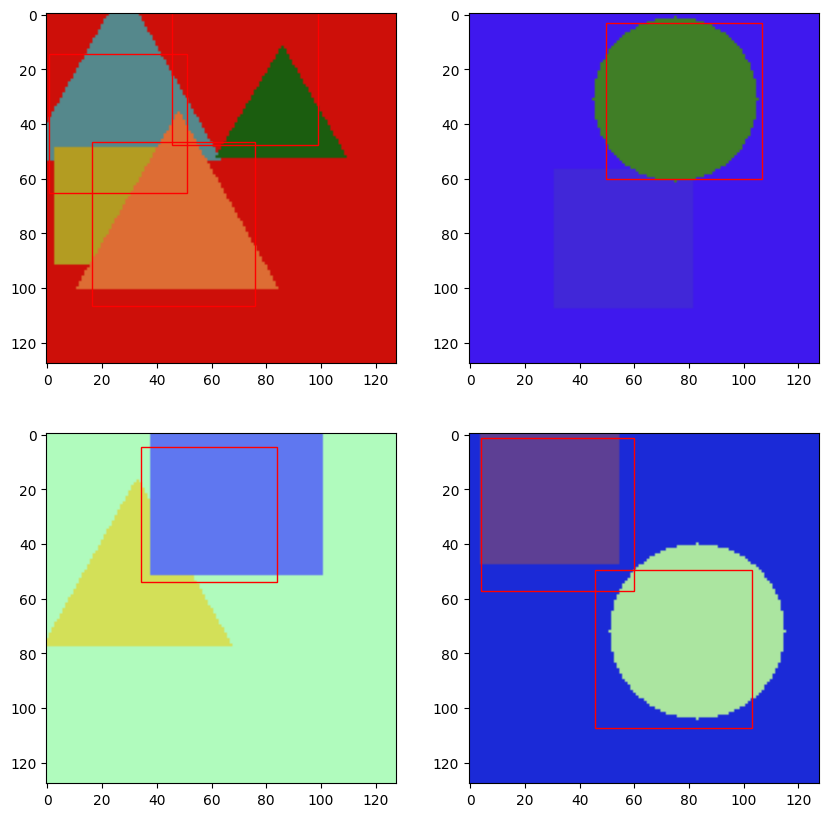

In [ ]:
def visualize_preds(model, sample):
    model = model.to('cpu')

    label_preds, offset_preds = model(sample)


    foreground_threshold = 0.7
    anchors = get_anchors()
    predictions = []
    iou_threshold = 0.3
    label_preds = label_preds.sigmoid()
    for i in range(4):
      label_pred = label_preds[i]
      offset_pred = offset_preds[i]
      selected_anchors = anchors[label_pred > foreground_threshold]
      offset_pred = offset_pred[label_pred > foreground_threshold]
      label_pred = label_pred[label_pred > foreground_threshold]

      selected_anchors = apply_offsets(selected_anchors, offset_pred)

      keep = nms(selected_anchors, label_pred, iou_threshold)
      predictions.append({'bounding_box' : selected_anchors[keep].data})

    visualize(sample, predictions)

visualize_preds(model, sample)